## In this note, we will discuss different numerical algorithm scheme in solving the shock-wave problem

In order to compare different types of algorithm, we will consider the following 1D diffusion equation,
$$ \partial_t u = - v \partial_x u $$
For a given initial condition $u(t=t_0, x)$, it's solution at later time $u(t, x)$ is known analytically,
$$ u(t, x) = u(t_0, x - vt) $$

Here, we first setup our initial condition $u(t=t_0, x)$ for this 1D diffusion problem. We choose $v = 0.5$.

In [1]:
%matplotlib inline
from numpy import *
from os import path
import matplotlib.pyplot as plt

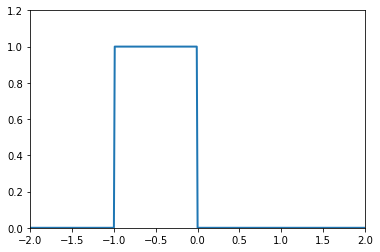

In [3]:
#initial setup
v = 0.5
x = linspace(-2, 5, 701)
dx = x[1] - x[0]
u0 = zeros(len(x))
idx = (x > -1) & (x < 0)
u0[idx] = 1.0        # square
#u0[idx] = -x[idx]   # triangle
plt.plot(x, u0, linewidth=2)
plt.xlim([-2, 2]);
plt.ylim([0, 1.2]);

In [4]:
# prepare the analytic solution
def get_analytic_solution(u0, delta_x, delta_t, n_step):
    u_analytic = zeros(len(u0))
    x_shift = (int)(n_step*delta_t/delta_x*v)
    u_analytic[x_shift:] = u0[:-x_shift]
    return(u_analytic)

### Forward-time centered-space (FTCS) method
The simplest numerical scheme would be
$$ u_{i}^{n+1} = u_{i}^n - \frac{v \Delta t}{2 \Delta x}(u_{i+1}^n - u_{i-1}^n). $$
This numerical scheme gives $ O((\Delta x)^2) $ in $x$ and $ O(\Delta t) $ in time.

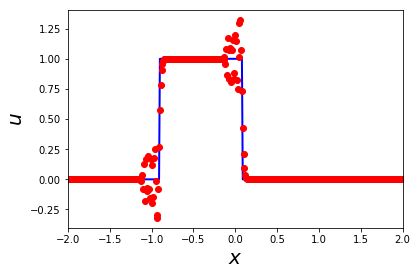

In [5]:
def evolve_FTCS_method(u_init, delta_x, delta_t, n_step):
    u_current = copy(u_init)
    u_next = zeros(len(u_init))
    for it in range(n_step):  
        for i in range(0, len(u_current)):
            if i == 0:
                u_next[i] = u_current[i] - v*delta_t/delta_x*(u_current[i+1] - u_current[i])
            elif i == len(u_current)-1:
                u_next[i] = u_current[i] - v*delta_t/delta_x*(u_current[i] - u_current[i-1])
            else:
                u_next[i] = (u_current[i] - v*delta_t/(2.*delta_x)
                                            *(u_current[i+1] - u_current[i-1]))
        u_current = copy(u_next)
    return(u_next)

# numerical evolution
dt = 0.001       # make sure delta_t/delta_x < 1
nt = 200         # evolve 200 time step
u_analytic = get_analytic_solution(u0, dx, dt, nt)
u_now = evolve_FTCS_method(u0, dx, dt, nt)

# check numerical solution
fig = plt.figure()
plt.plot(x, u_analytic, '-b', linewidth=2)
plt.plot(x, u_now, 'or')
plt.xlim([-2, 2])
plt.ylabel(r'$u$', fontsize=20)
plt.xlabel(r'$x$', fontsize=20);

### Upwind scheme
To fix this problem, we can try the first scheme for the spatial derivative,
$$ u_{i}^{n+1} = u_{i}^n - \frac{v \Delta t}{\Delta x}(u_{i}^n - u_{i-1}^n). $$
This numerical scheme gives $ O((\Delta x)) $ in $x$ and $ O(\Delta t) $ in time.

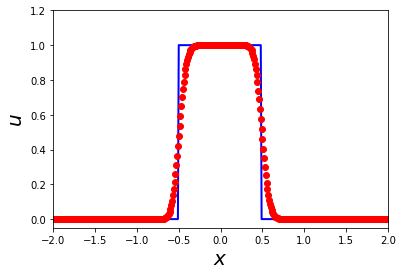

In [6]:
def evolve_upwind_method(u_init, delta_x, delta_t, n_step):
    u_current = copy(u_init)
    u_next = zeros(len(u_init))
    for it in range(n_step):  
        for i in range(0, len(u_current)):
            if i == 0:
                u_next[i] = u_current[i] - v*delta_t/delta_x*(u_current[i+1] - u_current[i])
            else:
                u_next[i] = u_current[i] - v*delta_t/delta_x*(u_current[i] - u_current[i-1])
        u_current = copy(u_next)
    return(u_next)

# numerical evolution
dt = 0.001        # make sure delta_t/delta_x < 1
nt = 1000         # evolve 1000 time step
u_analytic = get_analytic_solution(u0, dx, dt, nt)
u_now = evolve_upwind_method(u0, dx, dt, nt)

# check numerical solution
fig = plt.figure()
plt.plot(x, u_analytic, '-b', linewidth=2)
plt.plot(x, u_now, 'or')
plt.xlim([-2, 2])
plt.ylabel(r'$u$', fontsize=20)
plt.xlabel(r'$x$', fontsize=20)
plt.ylim([-0.05, 1.2]);

The positivity is maintained in this up-wind scheme. However, as the system evolves in time, the shape of the solution gets more and more distored. (try nt = 1000)
This is because the higher order correction to the spatial derivatives in this scheme is
$$ \frac{u_i^n - u_{i-1}^n}{\Delta x} = \partial_x u(t_n, x_i) - \frac{\Delta x}{2} \partial_x^2 u(t_n, x_i) + O((\Delta x)^2)$$
The term $\partial_x^2 u(t_n, x_i)$ generates too much numerical viscosity, which smear out the sharpness of the shape of the function.

Thus, we need better discretization scheme which ensure the positivity and achieve higher order accuracy in $\Delta x$.


## Finite Element Methods
For a fluid cell $i$ the conservation law equation can be written as,
$$ \bar{u}_i^{n+1} = \bar{u}_i^n - \frac{1}{\Delta x} \int_{t_n}^{t_{n+1}} dt \bigg(v \bar{u}^n_{i+1/2} - v \bar{u}^n_{i-1/2} \bigg) $$
where $i\pm1/2$ are the cell boundaries.

Approximating the time integral by midpoint rule, we get
$$ \bar{u}_i^{n+1} = \bar{u}_i^n - \frac{v\Delta t}{\Delta x} \bigg(  \bar{u}^{n+1/2}_{i+1/2} - \bar{u}^{n+1/2}_{i-1/2} \bigg)  $$

In order to evaluate the values of $\bar{u}$ at the boundaries $i\pm1/2$, we can use a staggered method. In the first step, we evaluate $\bar{u}^{n+1}$ at $i+1/2$ and second step we jump half step back to $\bar{u}^{n+2}_{i}$.

$$ \bar{u}^{n+1}_{i+1/2} = \frac{\bar{u}^n_{i+1} + \bar{u}^n_i}{2} - \frac{v \Delta t}{\Delta x} \bigg( \bar{u}^{n+1/2}_{i+1} - \bar{u}^{n+1/2}_{i} \bigg) $$

Here we use $\bar{u}^{n}_{i+1/2} = (\bar{u}^n_{i+1} + \bar{u}^n_i)/2$ at the current time step $t_n$. The halfway time step quantities can be evaluated using the forward Euler method,

$$ \bar{u}^{n+1/2}_i = \bar{u}^n_i - \frac{\Delta t}{2} (\partial_x u)^n_i $$

This is a generalized Lax-Friedrichs method.

### generalized minmod flux limiter

To evaluate the spatial derivative, $(\partial_x u)^n_i$, we already know that the central difference scheme could be unstable when the gradient is large. But it is OK to use in the smooth region. So here we introduce a scheme which can switch between centeral difference scheme and first order scheme based on the local gradient:

$$ (\partial_x u)^n_i = \left\{ \begin{array}{cc} 0 & \mbox{if } \bar{u}_i^n < \bar{u}^n_{i\pm1} \mbox{ or } \bar{u}_i^n > \bar{u}^n_{i\pm1} \\ sign(\bar{u}^n_{i+1} - \bar{u}^n_i)min \left(\theta \frac{\vert \bar{u}_{i+1}^n - \bar{u}_{i}^n \vert}{\Delta x}, \frac{\vert \bar{u}_{i+1}^n - \bar{u}_{i-1}^n \vert}{2 \Delta x} , \theta \frac{\vert \bar{u}_{i}^n - \bar{u}_{i-1}^n \vert}{\Delta x} \right) & \mbox{otherwise} \end{array} \right.$$

The the parameter $\theta$ is called the flux limiter, $1 \le \theta < 2$ in general.

In [7]:
def minmod(u_left, u_mid, u_right, delta_x, theta=1.8):
    if (u_left - u_mid)*(u_right - u_mid) > 0:
        return(0)
    else:
        dudx_left = (u_mid - u_left)/delta_x
        dudx_right = (u_right - u_mid)/delta_x
        dudx_mid = (u_right - u_left)/(2.*delta_x)
        if u_right > u_mid:
            dudx = min([dudx_left*theta, dudx_mid, dudx_right*theta])
        else:
            dudx = max([dudx_left*theta, dudx_mid, dudx_right*theta])
        return(dudx)

### Generalized Lax-Friedrichs method

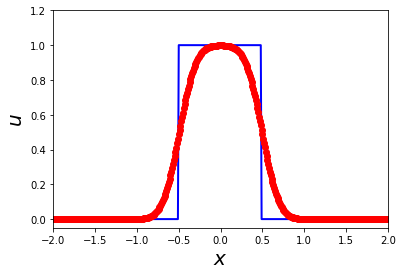

In [8]:
def evolve_LaxFriedrichs_method(u_init, delta_x, delta_t, n_step):
    u_current = copy(u_init)
    u_next = zeros(len(u_init))
    dudx = zeros(len(u_init))
    u_half = zeros(len(u_init))
    for it in range(nt):
        for i in range(0, len(u_current)):  # compute dudx using minmod flux limiter
            if i == 0:
                dudx = minmod(u_current[i], u_current[i], u_current[i+1], delta_x)
            elif i == len(u_current)-1:
                dudx = minmod(u_current[i-1], u_current[i], u_current[i], delta_x)
            else:
                dudx = minmod(u_current[i-1], u_current[i], u_current[i+1], delta_x)
        u_half = u_current - delta_t/2.*dudx
        for i in range(0, len(u_current)):
            if it%2 == 0:  # staggered evolution between i and i+1/2
                if i == len(u_current) - 1:
                    u_next[i] = ((u_current[i] + u_current[i-1])/2.
                                 - v*delta_t/delta_x*(u_half[i] - u_half[i-1]))
                else:
                    u_next[i] = ((u_current[i+1] + u_current[i])/2.
                                 - v*delta_t/delta_x*(u_half[i+1] - u_half[i]))
            else:
                if i == 0:
                    u_next[i] = ((u_current[i+1] + u_current[i])/2.
                                 - v*delta_t/delta_x*(u_half[i+1] - u_half[i]))
                else:
                    u_next[i] = ((u_current[i] + u_current[i-1])/2.
                                 - v*delta_t/delta_x*(u_half[i] - u_half[i-1]))
        u_current = copy(u_next)
    return(u_next)

# check numerical solution
dt = 0.001        # make sure delta_t/delta_x < 1
nt = 1000         # evolve 1000 time step
u_analytic = get_analytic_solution(u0, dx, dt, nt)
u_now = evolve_LaxFriedrichs_method(u0, dx, dt, nt)

fig = plt.figure()
plt.plot(x, u_analytic, '-b', linewidth=2)
plt.plot(x, u_now, 'or')
plt.xlim([-2, 2]);
plt.ylabel(r'$u$', fontsize=20);
plt.xlabel(r'$x$', fontsize=20);
plt.ylim([-0.05, 1.2]);

We can see that the numerical viscosity is still quite large in this scheme. From the Taylor expation, we find
$$ \frac{\bar{u}^n_{i+1} + \bar{u}^n_i}{2} = \bar{u}^n_{i+1/2} + \frac{(\Delta x)^2}{8} \partial_x^2 u^n_{i+1/2} $$

The numerical viscosity comes with $\mathcal{O}(\Delta x^2)$. We need higher order scheme. 
### Second order Nessyahu-Tadmor (NT) Scheme

To improve the estimation of $\bar{u}^n_{i+1/2}$, we can use additional information from the first order derivative,

$$ \bar{u}^n_{i+1/2} = \bar{u}^n_{i} + \frac{\Delta x}{2} (\partial_x u)_i^n \quad \mbox{ or } \quad  \bar{u}^n_{i+1/2} = \bar{u}^n_{i+1} - \frac{\Delta x}{2} (\partial_x u)_{i+1}^n$$

In this case, we add a correction term,

$$ \bar{u}^{n+1}_{i+1/2} = \frac{\bar{u}^n_{i+1} + \bar{u}^n_i}{2} - \frac{v \Delta t}{\Delta x} \bigg( \bar{u}^{n+1/2}_{i+1} - \bar{u}^{n+1/2}_{i} \bigg) - \frac{\Delta x}{4}(\partial_x u)^n_{i+1} - (\partial_x u)^n_i) $$

The last term cancels the leading order numerical viscosity in the generalized Lax-Friedrichs method. This scheme is $\mathcal{O}(\Delta x^4)$ in the smooth region.

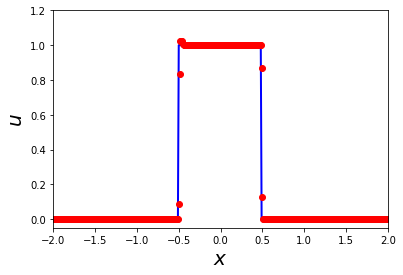

In [9]:
def evolve_NT_method(u_init, delta_x, delta_t, n_step):
    u_current = copy(u_init)
    u_next = zeros(len(u_init))
    u_half = zeros(len(u_init))
    dudx = zeros(len(u_init))
    for it in range(nt):
        for i in range(0, len(u_current)):
            if i == 0:
                dudx[i] = minmod(u_current[i], u_current[i], u_current[i+1], delta_x)
            elif i == len(u_current)-1:
                dudx[i] = minmod(u_current[i-1], u_current[i], u_current[i], delta_x)
            else:
                dudx[i] = minmod(u_current[i-1], u_current[i], u_current[i+1], delta_x)
        u_half = u_current - delta_t/2.*dudx
        for i in range(0, len(u_current)):
            if it%2 == 1:  # staggered evolution between i and i+1/2
                if i == len(u_current) - 1:
                    u_next[i] = ((u_current[i] + u_current[i-1])/2.
                                 - v*delta_t/delta_x*(u_half[i] - u_half[i-1])
                                 - delta_x/4.*(dudx[i] - dudx[i-1]))
                else:
                    u_next[i] = ((u_current[i+1] + u_current[i])/2.
                                 - v*delta_t/delta_x*(u_half[i+1] - u_half[i])
                                 - delta_x/4.*(dudx[i+1] - dudx[i]))
            else:
                if i == 0:
                    u_next[i] = ((u_current[i+1] + u_current[i])/2.
                                 - v*delta_t/delta_x*(u_half[i+1] - u_half[i])
                                 - delta_x/4.*(dudx[i+1] - dudx[i]))
                else:
                    u_next[i] = ((u_current[i] + u_current[i-1])/2.
                                 - v*delta_t/delta_x*(u_half[i] - u_half[i-1])
                                 - delta_x/4.*(dudx[i] - dudx[i-1]))
        u_current = copy(u_next)
    return(u_next)

# check numerical solution
dt = 0.001       # make sure delta_t/delta_x < 1
nt = 1000        # evolve 1000 time step
u_analytic = get_analytic_solution(u0, dx, dt, nt)
u_now = evolve_NT_method(u0, dx, dt, nt)

fig = plt.figure()
plt.plot(x, u_analytic, '-b', linewidth=2)
plt.plot(x, u_now, 'or')
plt.xlim([-2, 2]);
plt.ylabel(r'$u$', fontsize=20);
plt.xlabel(r'$x$', fontsize=20);
plt.ylim([-0.05, 1.2]);

The second order NT scheme works well in practice. However, one can not take $\Delta t$ to zero because the numerical viscosity behaves like $1/\Delta t$. It would be good to take the limit $\Delta t \rightarrow 0$ because one can then formulate the discretized problem as a set of coupled ordinary differential equations in time. Many techniques for the ordinary differential equations such as the Runge-Kutta methods become available to control the accuracy of the time evolution.

### The second order Kurganov-Tadmor (KT) algorithm

The idea of the KT algorithm is that the size of the cell which contains the discontinuity at the half integer point $x_{i+1/2}$ is controlled by the local propagation speed $c_{i+1/2}$. The cells containing the boundaries and the cells not containing the boundaries are independently evolved. 

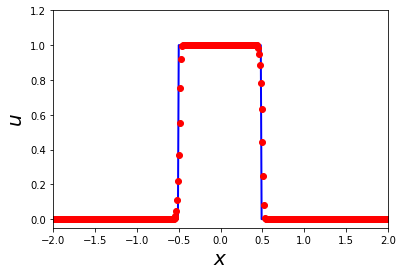

In [18]:
def evolve_KT_method(u_init, delta_x, delta_t, n_step):
    u_current = copy(u_init)
    dudx = zeros(len(u_init))
    u_plus_half = zeros(len(u_init))
    u_minus_half = zeros(len(u_init))
    H = zeros(len(u_init))
    u_half = copy(u_init)
    u_next = zeros(len(u_init))
    for it in range(nt):
        for rk_step in range(2):
            for i in range(len(u_half)):  # compute dudx using minmod flux limiter
                if i == 0:
                    dudx[i] = minmod(u_half[i], u_half[i], u_half[i+1], delta_x)
                elif i == len(u_current)-1:
                    dudx[i] = minmod(u_half[i-1], u_half[i], u_half[i], delta_x)
                else:
                    dudx[i] = minmod(u_half[i-1], u_half[i], u_half[i+1], delta_x)
            for i in range(len(u_half)):  # compute halfway cells
                if i == len(u_half) - 1:
                    u_plus_half[i] = u_half[i] - delta_x/2.*dudx[i]
                else:
                    u_plus_half[i] = u_half[i+1] - delta_x/2.*dudx[i+1]
            u_minus_half = u_half + delta_x/2.*dudx
            c_i = v
            H = ((v*u_plus_half + v*u_minus_half)/2. - c_i/2.*(u_plus_half - u_minus_half))
            if rk_step == 0:  # evlove time evolution with Runge-Kutta
                for i in range(len(u_half)):
                    if i == 0:
                        u_half[i] = u_half[i] - delta_t/delta_x*(H[i+1] - H[i])
                    else:
                        u_half[i] = u_half[i] - delta_t/delta_x*(H[i] - H[i-1])
            else:
                for i in range(len(u_half)):
                    if i == 0:
                        u_next[i] = u_half[i] - delta_t/delta_x*(H[i+1] - H[i])
                    else:
                        u_next[i] = u_half[i] - delta_t/delta_x*(H[i] - H[i-1])
                u_next = 0.5*(u_current + u_next)
                u_current = copy(u_next)  # update
                u_half = copy(u_next)
    return(u_next)

dt = 0.01  # make sure delta_t/delta_x < 1
nt = 100        # evolve 100 time step
u_analytic = get_analytic_solution(u0, dx, dt, nt)
u_now = evolve_KT_method(u0, dx, dt, nt)

# check numerical solution
fig = plt.figure()
plt.plot(x, u_analytic, '-b', linewidth=2)
plt.plot(x, u_now, 'or')
plt.xlim([-2, 2])
plt.ylabel(r'$u$', fontsize=20)
plt.xlabel(r'$x$', fontsize=20)
plt.ylim([-0.05, 1.2]);

### SHASTA

Text(0.5, 0, '$x$')

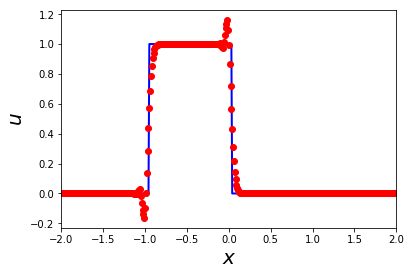

In [13]:
def minmod_SHASTA(w0, w1, w2, w3, deltax):
    delta_1 = (w1 - w0)/deltax
    delta_2 = (w2 - w1)/deltax
    delta_3 = (w3 - w2)/deltax
    if delta_1*delta_2 < 0 or delta_2*delta_3 < 0:
        return(0.0)
    else:
        if delta_2 > 0:
            return(min([delta_1, 1./8.*delta_2, delta_3]))
        else:
            return(max([delta_1, 1./8.*delta_2, delta_3]))
        
def evolve_SHASTA_method(u_init, delta_x, delta_t, n_step):
    epsilon = v*delta_t/delta_x
    u_current = copy(u_init)
    u_next = zeros(len(u_init))
    dudx = zeros(len(u_init))
    u_half = zeros(len(u_init))
    w_next = zeros(len(u_init))
    dwdx = zeros(len(u_init))
    for it in range(nt):
        for i in range(0, len(u_current)):
            if i == 0:
                dudx[i] = minmod(u_current[i], u_current[i], u_current[i+1], delta_x)
            elif i == len(u_current)-1:
                dudx[i] = minmod(u_current[i-1], u_current[i], u_current[i], delta_x)
            else:
                dudx[i] = minmod(u_current[i-1], u_current[i], u_current[i+1], delta_x)
        u_half = u_current - delta_t/2.*dudx
        for i in range(0, len(u_current)):
            if i == 0:
                w_next[i] = (u_current[i] - epsilon*(u_half[i+1] - u_half[i])
                             + 1./8.*(u_current[i+1] - 2.*u_current[i] + u_current[i]))
            elif i == len(u_current) - 1:
                w_next[i] = (u_current[i] - epsilon*(u_half[i] - u_half[i-1])
                             + 1./8.*(u_current[i] - 2.*u_current[i] + u_current[i-1]))
            else:
                w_next[i] = (u_current[i] - epsilon/2.*(u_half[i+1] - u_half[i-1])
                             + 1./8.*(u_current[i+1] - 2.*u_current[i] + u_current[i-1]))
        for i in range(0, len(u_current)):  # compute dw^{i+1}/dx
            if i == 0:
                dwdx[i] = minmod_SHASTA(w_next[i], w_next[i], w_next[i+1],
                                        w_next[i+2], delta_x)
            elif i == len(u_current) - 2:
                dwdx[i] = minmod_SHASTA(w_next[i-1], w_next[i], w_next[i+1],
                                        w_next[i+1], delta_x)
            elif i == len(u_current) - 1:
                dwdx[i] = minmod_SHASTA(w_next[i-1], w_next[i], w_next[i],
                                        w_next[i], delta_x)
            else:
                dwdx[i] = minmod_SHASTA(w_next[i-1], w_next[i], w_next[i+1],
                                        w_next[i+2], delta_x)          
        for i in range(0, len(u_current)):  # anti-diffusion stage
            if i == len(u_current)-1:
                u_next[i] = w_next[i] - delta_x*(dwdx[i] - dwdx[i-1])
            else:
                u_next[i] = w_next[i] - delta_x*(dwdx[i+1] - dwdx[i])
        u_current = copy(u_next)  # update
    return(u_next)

dt = 0.001  # make sure delta_t/delta_x < 1
nt = 100        # evolve 100 time step
u_analytic = get_analytic_solution(u0, dx, dt, nt)
u_now = evolve_SHASTA_method(u0, dx, dt, nt)

# check numerical solution
fig = plt.figure()
plt.plot(x, u_analytic, '-b', linewidth=2)
plt.plot(x, u_now, 'or')
plt.xlim([-2, 2]);
plt.ylabel(r'$u$', fontsize=20);
plt.xlabel(r'$x$', fontsize=20)